# Planejamento da Solução

## Input

1. Problema de negócio
 - Selecionar os clientes mais valiosos para criar um programa de fidelidade
2. Conjunto de dados
 - Vendas de e-commerce no período de um ano

## Output

1. <b>Indicação das pessoas que farão parte do programa de fidelidade
    - Tabela com: <br>
            |customerid | is_insider| 
            |    1      |     yes   | 
            |    2      |     no    | 
 
2. <b>Responder as perguntas de negócio:
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Tasks

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior valor?
    - Faturamento:
        - Alto Ticket médio
        - Alto LTV
        - Baixa recência (compra mais frequentemente)
        - Alto basket size (tamanho de cesta)
        - Baixa probabilidade de churn (periodo que passa e não vai mais comprar)
        - Alta previsão de LTV
        - Alta propensão de compra
    - Custo:
        - Baixa taxa de devolução
    - Experiência de compra:
        - Alta média das avaliações
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo Insiders
    
    
3. Quais as principais características desses clientes ?
    - Escrever características do cliente (podem ser utilizadas para busca clientes semelhantes)
        - Idade
        - Localização
    - Escrever caacterísticas do consumo
        - Atributos da clusterização
        
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort (como um grupo de pessoas se comporta ao longo do tempo)
        - Sabendo que pessoas que compram calça na primeira compram geram maior faturamento futuro, posso otimizar campanhas
        - Pessoas da localidade X trazem maior faturamento 
    

6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a perodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar com uma pessoa do grupo
    

7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a perodicidade (1 mes, 3 meses)
    - A pessoa precisa ser não parecida com uma pessoa do grupo (começa a se distanciar do cluster)


8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses

9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frete
    - Visita a empresa


# 0.0. IMPORTS

In [1]:
import pandas as pd
import seaborn as sns

import plotly.express as px

from matplotlib import pyplot as plt
from IPython.display import HTML

In [2]:
from sklearn import cluster as c
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics as m

## 0.1. Helper Functions

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 24
    
    display(HTML ('<style>.container { width:95% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows=30
    pd.set_option('display.expand_frame_repr', False)
       
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
data_raw = pd.read_csv('../datasets/Ecommerce.csv',encoding='latin-1')
data_raw.drop(columns=['Unnamed: 8'], inplace=True)

# 1.0. PASSO 01 - DATA DESCRIPTION

In [5]:
df1 = data_raw.copy()
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## 1.1. Rename Columns

In [6]:
df1.columns = df1.columns.to_series().str.lower()

## 1.2. Data Dimensions

In [7]:
print(f'Counting {df1.shape[0]} rows and {df1.shape[1]} columns')

Counting 541909 rows and 8 columns


## 1.3. Data Types

In [8]:
df1.dtypes

invoiceno       object
stockcode       object
description     object
quantity         int64
invoicedate     object
unitprice      float64
customerid     float64
country         object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

invoiceno           0
stockcode           0
description      1454
quantity            0
invoicedate         0
unitprice           0
customerid     135080
country             0
dtype: int64

## 1.5. Fillout NA's

In [10]:
# first cicle --> remove NA's
print(f'Removing {df1.shape[0] - df1.dropna().shape[0]} rows')
df1 = df1.dropna()

print(f'Remain: {df1.shape[0]} rows')

Removing 135080 rows
Remain: 406829 rows


## 1.6. Verifying Types

In [11]:
# invoice date
df1['invoicedate'] = pd.to_datetime(df1['invoicedate'], format='%d-%b-%y')

# customerid 
df1['customerid'] = df1['customerid'].astype('int64')

df1.dtypes

invoiceno              object
stockcode              object
description            object
quantity                int64
invoicedate    datetime64[ns]
unitprice             float64
customerid              int64
country                object
dtype: object

## 1.7. Descriptive Statistics

### 1.7.1. Numerical Attributes

### 1.7.1. Categorical Attributes

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [12]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

## 2.2. Criacao das Hipoteses

### 2.1.1. Hipoteses Loja

### 2.1.2. Hipoteses Produto

### 2.1.3. Hipoteses Tempo

## 2.3. Lista final de hipoteses
--> Selecionando as hipoteses que posso validar com os dados nesse momento

## 2.4. Feature Engineering

In [13]:
# creating a reference dataframe --> only id's
df_reference = df2[['customerid']].drop_duplicates(ignore_index=True)

# Revenue --> Faturamento --> Quantity * Price
df2['revenue'] = df2['quantity'] * df2['unitprice']
revenue_per_client = df2[['customerid', 'revenue']].groupby('customerid').sum()
df_reference = df_reference.merge(revenue_per_client, on='customerid')

# Recency --> Today - Last day purchase
last_buy_date_per_client = df2[['customerid', 'invoicedate']].groupby('customerid').max().reset_index()
df_reference = df_reference.merge(last_buy_date_per_client, on='customerid')
df_reference['invoicedate'] = (df2['invoicedate'].max() - df_reference['invoicedate']).dt.days

# Frequency
helper_group = df2[['customerid', 'invoiceno', 'quantity']].groupby(['customerid', 'invoiceno']).count().reset_index()
frequency_per_client = helper_group[['customerid', 'quantity']].groupby('customerid').count().reset_index()
df_reference = df_reference.merge(frequency_per_client, on='customerid')


df_reference = df_reference.rename(columns={'invoicedate': 'recency', 'quantity': 'frequency'})



# Avg ticket
df_reference['avg_ticket'] = df_reference['revenue'] / df_reference['frequency']


df_reference.head()

,customerid,revenue,recency,frequency,avg_ticket
0,17850,5288.63,302,35,151.103714
1,13047,3079.10,31,18,171.061111
2,12583,7187.34,2,18,399.296667
3,13748,948.25,95,5,189.650000
4,15100,635.10,330,6,105.850000


In [14]:
df_reference

,customerid,revenue,recency,frequency,avg_ticket
0,17850,5288.63,302,35,151.103714
1,13047,3079.10,31,18,171.061111
2,12583,7187.34,2,18,399.296667
3,13748,948.25,95,5,189.650000
4,15100,635.10,330,6,105.850000
...,...,...,...,...,...
4367,13436,196.89,1,1,196.890000
4368,15520,343.50,1,1,343.500000
4369,13298,360.00,1,1,360.000000
4370,14569,227.39,1,1,227.390000


# 3.0. PASSO 03 - FILTRAGEM DE VARIAVEIS

In [15]:
df3 = df_reference.copy()

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [16]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

### 4.1.2. Numerical Variable

### 4.1.3. Categorical Variable

## 4.2. Analise Bivariada

### 4.2.1. Resumo das Hipoteses

## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

### 4.3.2. Categorical Attributes

# 5.0. PASSO 05 - PREPARAÇAO DOS DADOS

In [17]:
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Scaling

## 5.3. Transformacao

### 5.3.1. Encoding

### 5.3.2. Response Variable Transformation

### 5.3.3. Nature Transformation

# 6.0. PASSO 06 - FEATURE SELECTION

In [18]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test

## 6.2. Feature Selection

# 7.0. PASSO 07 - FINDING THE NUMBER OF CLUSTERS

HYPERPARAMETER FINE TUNING

In [19]:
df7 = df6.copy()

In [20]:
X = df7.drop(columns=['customerid'])

In [21]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluste Sum of Square (WSS)

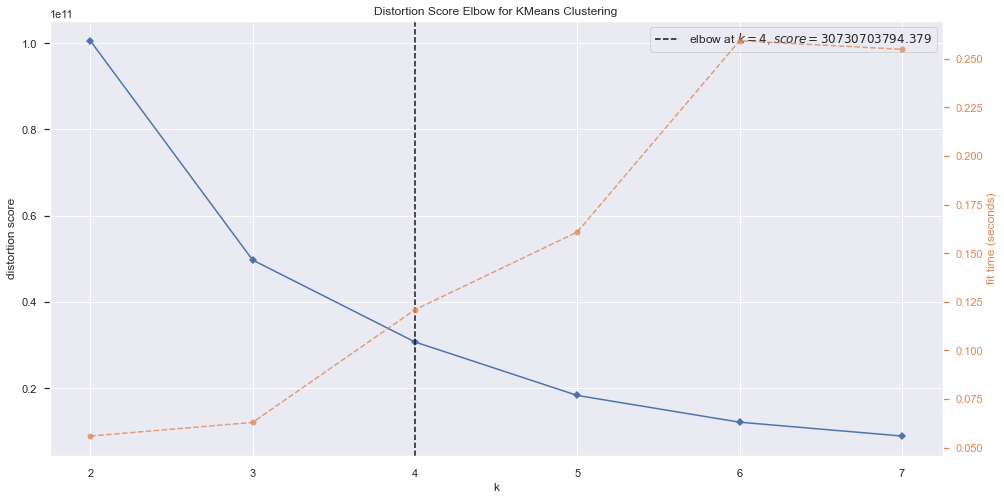

In [22]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timing=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Score (SS)

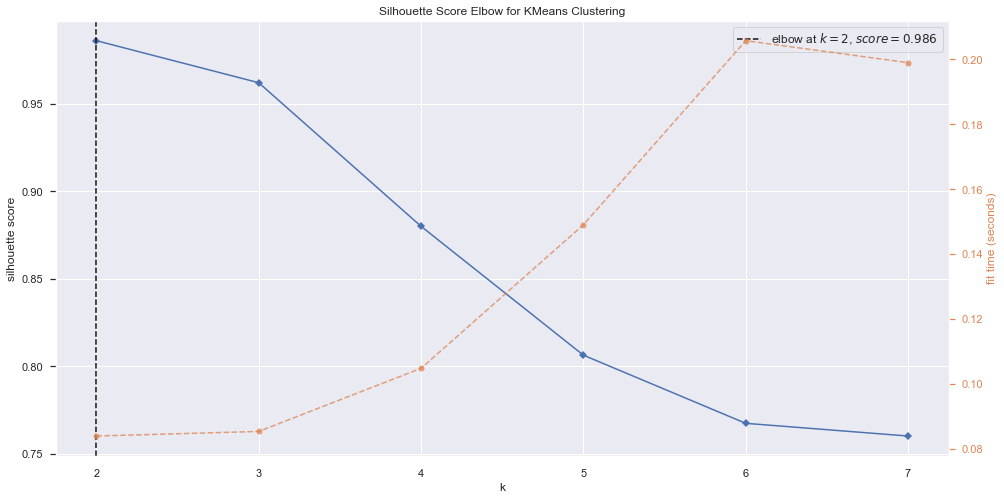

In [23]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette',timing=False)
kmeans.fit(X)
kmeans.show();

## 7.2. Silhouette Analysis

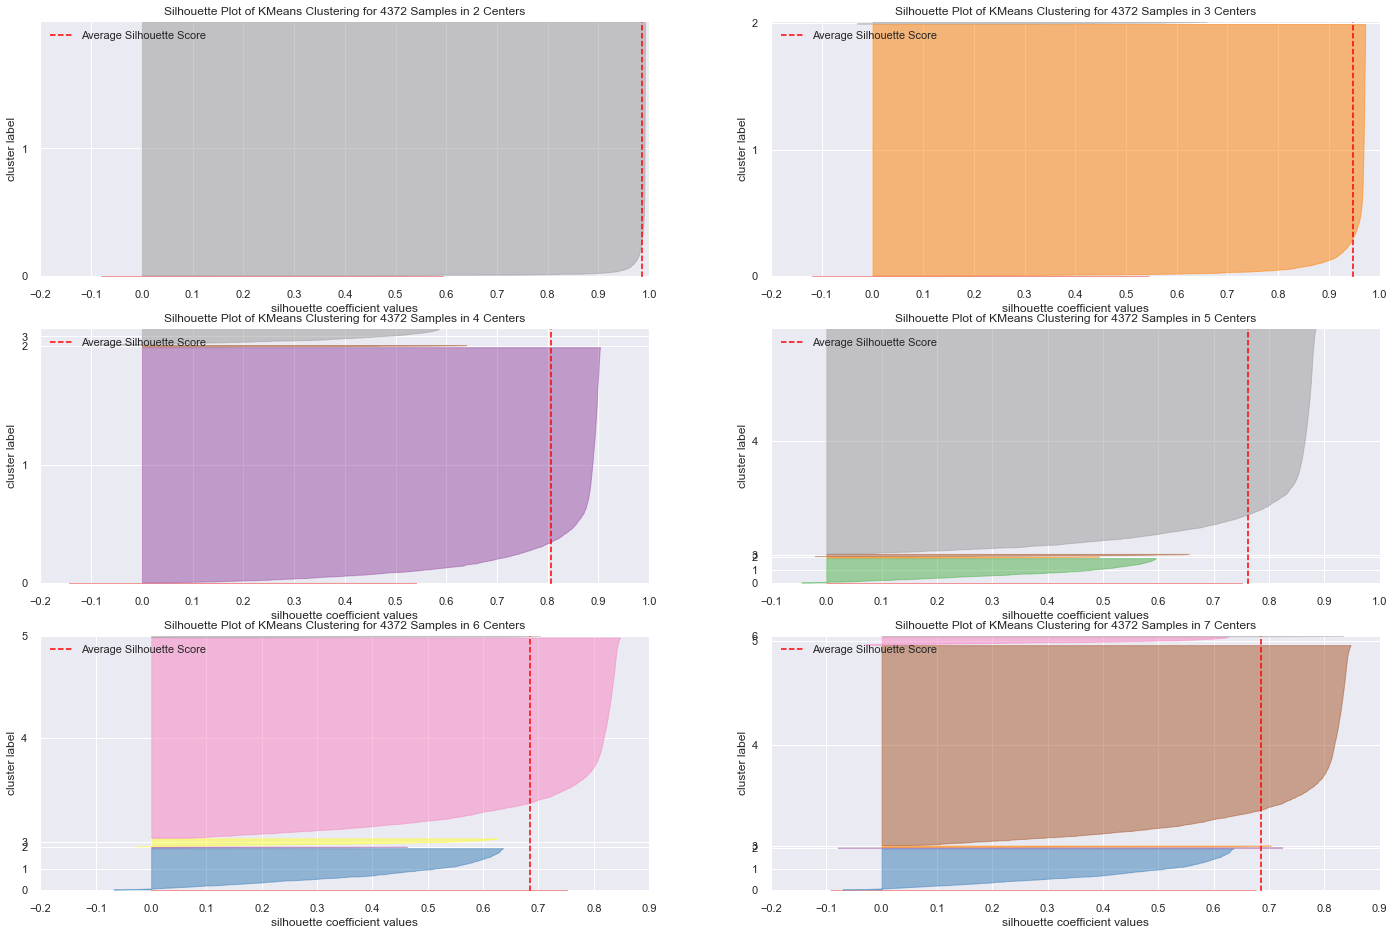

In [24]:
fig, ax = plt.subplots(3,2,figsize=(24,16))
for k in clusters:
    km = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=99)
    
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize();

# 8.0. PASSO 08 - MODEL TRAINING

## 8.1. K-Means

In [25]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=99)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1. Cluster Validation

In [26]:
# WSS 
print(f'WSS: {kmeans.inertia_:.2f}')

# SS
print(f'SS: {m.silhouette_score(X, labels, metric="euclidean"):.3f}')

WSS: 40463518784.46
SS: 0.806


# 9.0. PASSO 09 - CLUSTER ANALYSIS

In [27]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customerid,revenue,recency,frequency,avg_ticket,cluster
0,17850,5288.63,302,35,151.103714,3
1,13047,3079.10,31,18,171.061111,1
2,12583,7187.34,2,18,399.296667,3
3,13748,948.25,95,5,189.650000,1
4,15100,635.10,330,6,105.850000,1


## 9.1. Visualization Inspection

In [28]:
# fig = px.scatter_3d(df9, x='recency', y='frequency', z='revenue', color='cluster')
# fig.show()

C:\Users\Miguel\anaconda3\envs\pa005\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


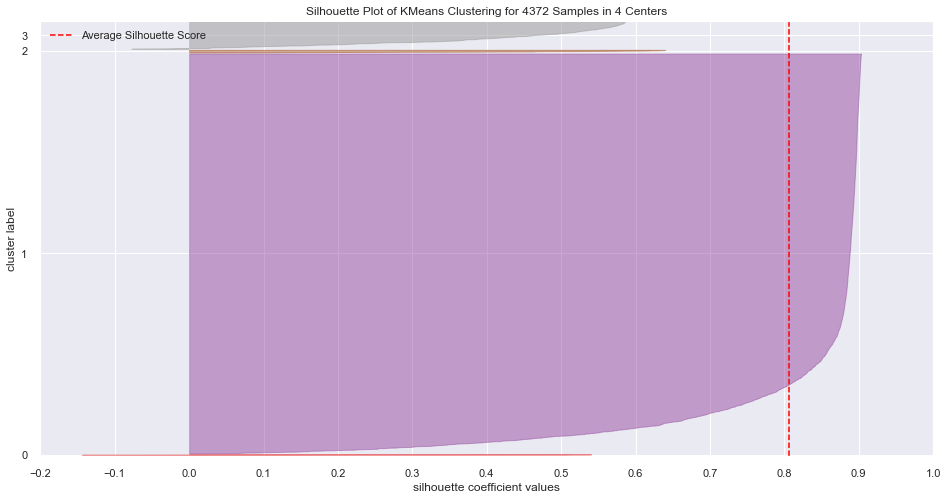

In [29]:
visualizer = SilhouetteVisualizer(kmeans, color='yellowbrick')
visualizer.fit(X)
visualizer.finalize();

## 9.1.1. 2d plot

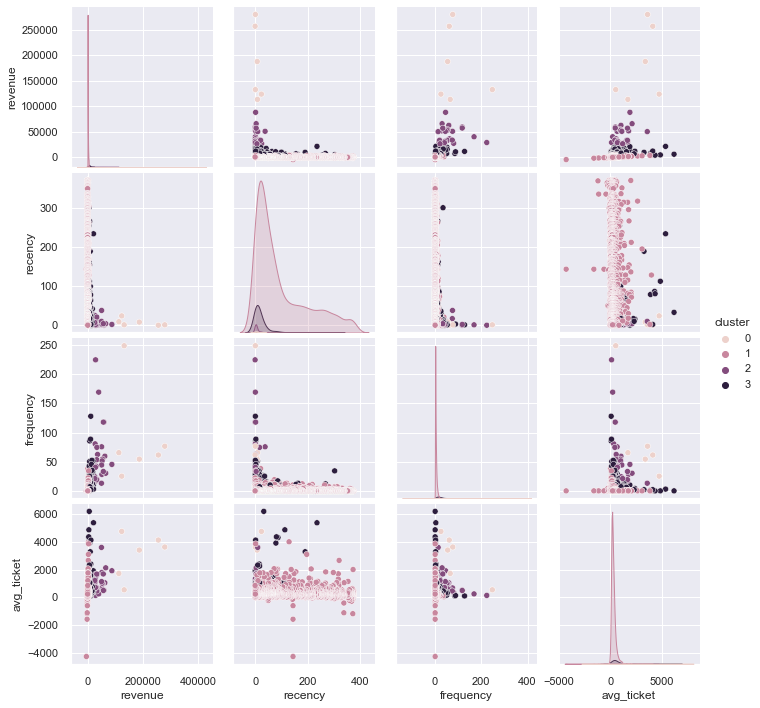

In [30]:
df_viz = df9.drop(columns=['customerid'])
sns.pairplot(df_viz, hue='cluster');

## 9.1.2. Machine Learning - Manifold

- Redução de dimensionalidade
1. PCA - Matrix, Espaço de Distância - Espaço de Hilbert - 9 Condições - Colorários

2. UMAP, t-SNE (2009) - Manifold - Topologia

In [44]:
import umap.umap_ as ump

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

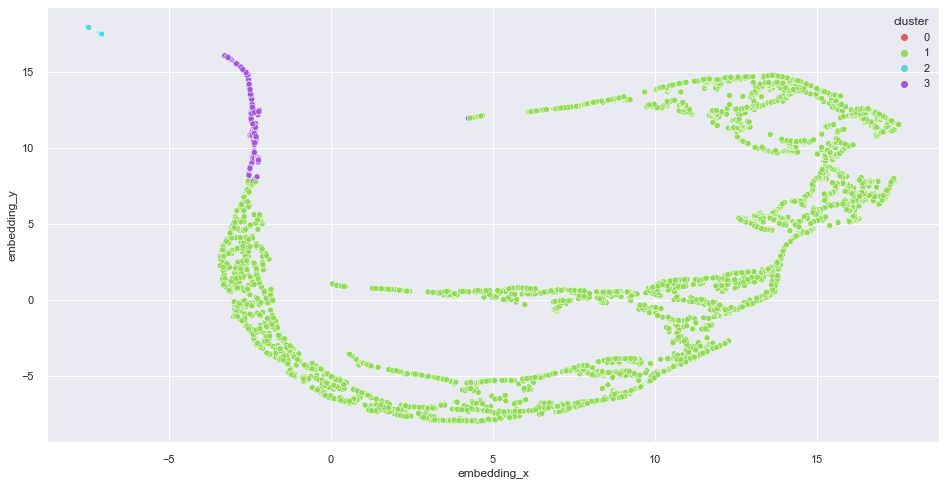

In [50]:
# projeção do X em outro espaço
reducer = ump.UMAP(random_state=99,n_neighbors=20 ) # n_neighbors --> como se representasse um zoom (olhando globalmente)
embedding = reducer.fit_transform(X)

# embedding 
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot
sns.scatterplot(data=df_viz, x='embedding_x', y='embedding_y', hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())))

# pontos proximos da mesma cor --> na alta dimensionalidade a probabilidade de estarem proximos é alta

## 9.2. Cluster Profile

In [45]:
# Number of customers
df_profile = pd.DataFrame({'count': df9['cluster'].value_counts(), 
                                    'percent': df9['cluster'].value_counts(normalize=True) * 100})

df_profile.index.name = 'cluster'

df_profile = df_profile.reset_index()

# Average in other metrics
average_metrics_by_cluster = df9.drop(columns=['customerid']).groupby('cluster').mean().reset_index()


df_profile = df_profile.merge(average_metrics_by_cluster, on='cluster').sort_values('revenue', ascending=False)
df_profile

,cluster,count,percent,revenue,recency,frequency,avg_ticket
3,0,6,0.137237,182181.981667,7.166667,89.000000,3030.963104
2,2,28,0.640439,42614.387143,6.178571,57.821429,1110.061535
1,3,273,6.244282,8008.702454,21.575092,19.208791,660.024826
0,1,4065,92.978042,941.548663,96.995572,3.639114,283.293476


In [46]:
for _,linha in df_profile.iterrows():
    print(f"Cluster {linha['cluster']+1:.0f}")
    print(f"Número de clientes: {linha['count']:.0f} ({linha['percent']:.2f}% da base)")
    print(f"Recência em média: {linha['recency']:.2f} dias")
    print(f"Frequência média: {linha['frequency']:.2f} compras")
    print(f"Receita em média: U$ {linha['revenue']:,.2f}")
    print(f"AVG Ticket: U$ {linha['avg_ticket']:,.2f}/compra")
    print('\n')

Cluster 1
Número de clientes: 6 (0.14% da base)
Recência em média: 7.17 dias
Frequência média: 89.00 compras
Receita em média: U$ 182,181.98
AVG Ticket: U$ 3,030.96/compra


Cluster 3
Número de clientes: 28 (0.64% da base)
Recência em média: 6.18 dias
Frequência média: 57.82 compras
Receita em média: U$ 42,614.39
AVG Ticket: U$ 1,110.06/compra


Cluster 4
Número de clientes: 273 (6.24% da base)
Recência em média: 21.58 dias
Frequência média: 19.21 compras
Receita em média: U$ 8,008.70
AVG Ticket: U$ 660.02/compra


Cluster 2
Número de clientes: 4065 (92.98% da base)
Recência em média: 97.00 dias
Frequência média: 3.64 compras
Receita em média: U$ 941.55
AVG Ticket: U$ 283.29/compra




# 10.0. PASSO 10 - DEPLOY TO PRODUCTION